<a href="https://colab.research.google.com/github/sadhanasharma26/basic-gans-on-CIFAR-10-image-dataset/blob/main/cifar_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define a basic transform
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [3]:
train_dataset = datasets.CIFAR10(root='./data',\
			train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
								batch_size=32, shuffle=True)


100%|██████████| 170498071/170498071 [00:16<00:00, 10598532.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10


In [5]:
# Define the generator
class Generator(nn.Module):
	def __init__(self, latent_dim):
		super(Generator, self).__init__()

		self.model = nn.Sequential(
			nn.Linear(latent_dim, 128 * 8 * 8),
			nn.ReLU(),
			nn.Unflatten(1, (128, 8, 8)),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 128, kernel_size=3, padding=1),
			nn.BatchNorm2d(128, momentum=0.78),
			nn.ReLU(),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64, momentum=0.78),
			nn.ReLU(),
			nn.Conv2d(64, 3, kernel_size=3, padding=1),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		return img


In [6]:
# Define the discriminator
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()

		self.model = nn.Sequential(
		nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
		nn.ZeroPad2d((0, 1, 0, 1)),
		nn.BatchNorm2d(64, momentum=0.82),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
		nn.BatchNorm2d(128, momentum=0.82),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
		nn.BatchNorm2d(256, momentum=0.8),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Flatten(),
		nn.Linear(256 * 5 * 5, 1),
		nn.Sigmoid()
	)

	def forward(self, img):
		validity = self.model(img)
		return validity


In [7]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
						, lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
						, lr=lr, betas=(beta1, beta2))


Epoch [1/10]						Batch 100/1563 Discriminator Loss: 0.5165 Generator Loss: 1.4944
Epoch [1/10]						Batch 200/1563 Discriminator Loss: 0.5432 Generator Loss: 1.0692
Epoch [1/10]						Batch 300/1563 Discriminator Loss: 0.5252 Generator Loss: 0.9871
Epoch [1/10]						Batch 400/1563 Discriminator Loss: 0.5205 Generator Loss: 1.4452
Epoch [1/10]						Batch 500/1563 Discriminator Loss: 0.5678 Generator Loss: 1.4449
Epoch [1/10]						Batch 600/1563 Discriminator Loss: 0.5924 Generator Loss: 1.0829
Epoch [1/10]						Batch 700/1563 Discriminator Loss: 0.7112 Generator Loss: 0.8180
Epoch [1/10]						Batch 800/1563 Discriminator Loss: 0.6754 Generator Loss: 1.0005
Epoch [1/10]						Batch 900/1563 Discriminator Loss: 0.6581 Generator Loss: 0.9321
Epoch [1/10]						Batch 1000/1563 Discriminator Loss: 0.6248 Generator Loss: 0.8776
Epoch [1/10]						Batch 1100/1563 Discriminator Loss: 0.5662 Generator Loss: 0.9339
Epoch [1/10]						Batch 1200/1563 Discriminator Loss: 0.7636 Generator Loss: 0.8225
E

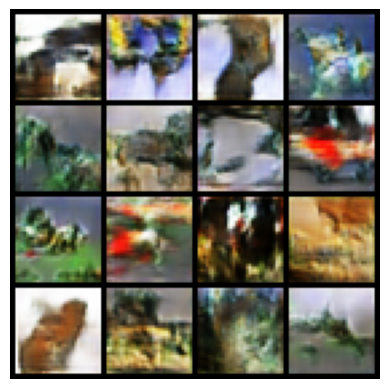

In [8]:
# Training loop
for epoch in range(num_epochs):
	for i, batch in enumerate(dataloader):
	# Convert list to tensor
		real_images = batch[0].to(device)
		# Adversarial ground truths
		valid = torch.ones(real_images.size(0), 1, device=device)
		fake = torch.zeros(real_images.size(0), 1, device=device)
		# Configure input
		real_images = real_images.to(device)

		# ---------------------
		# Train Discriminator
		# ---------------------
		optimizer_D.zero_grad()
		# Sample noise as generator input
		z = torch.randn(real_images.size(0), latent_dim, device=device)
		# Generate a batch of images
		fake_images = generator(z)

		# Measure discriminator's ability
		# to classify real and fake images
		real_loss = adversarial_loss(discriminator\
									(real_images), valid)
		fake_loss = adversarial_loss(discriminator\
									(fake_images.detach()), fake)
		d_loss = (real_loss + fake_loss) / 2
		# Backward pass and optimize
		d_loss.backward()
		optimizer_D.step()

		# -----------------
		# Train Generator
		# -----------------

		optimizer_G.zero_grad()
		# Generate a batch of images
		gen_images = generator(z)
		# Adversarial loss
		g_loss = adversarial_loss(discriminator(gen_images), valid)
		# Backward pass and optimize
		g_loss.backward()
		optimizer_G.step()
		# ---------------------
		# Progress Monitoring
		# ---------------------
		if (i + 1) % 100 == 0:
			print(
				f"Epoch [{epoch+1}/{num_epochs}]\
						Batch {i+1}/{len(dataloader)} "
				f"Discriminator Loss: {d_loss.item():.4f} "
				f"Generator Loss: {g_loss.item():.4f}"
			)
	# Save generated images for every epoch
	if (epoch + 1) % 10 == 0:
		with torch.no_grad():
			z = torch.randn(16, latent_dim, device=device)
			generated = generator(z).detach().cpu()
			grid = torchvision.utils.make_grid(generated,\
										nrow=4, normalize=True)
			plt.imshow(np.transpose(grid, (1, 2, 0)))
			plt.axis("off")
			plt.show()
